In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Libraries

In [141]:
from torchvision.transforms import Compose, ToTensor

In [142]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import EWC
from avalanche.training.plugins import EvaluationPlugin
from avalanche.benchmarks.generators import nc_benchmark
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    bwt_metrics,
    forgetting_metrics,
    accuracy_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD

In [110]:
from tqdm import tqdm

In [111]:
import pandas as pd
import seaborn as sns

## Custom Libraries

In [112]:
import sys
sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH
from base_code.models.mlp import MLP

# Dataset and definitions

## Preprocessing definitions

In [121]:
train_transform = Compose([
    ToTensor(),
])

test_transform = Compose([
    ToTensor(),
])

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [151]:
# mnist_train = MNIST(DATASETS_PATH, train=True, download=True, transform=train_transform)
# mnist_test = MNIST(DATASETS_PATH, train=False, download=True, transform=test_transform)

scenario = PermutedMNIST(10, seed=1234, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [152]:
# scenario = nc_benchmark(
#     mnist_train, mnist_test,
#     n_experiences=len(mnist_train.classes), shuffle=True, seed=1234, task_labels=False
# )

train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [153]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()]
)

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [154]:
# model = MLP(n_classes=scenario.n_classes, n_channels=1, width=28, height=28)
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28*28, hidden_layers=1, hidden_size=512, drop_rate=0)
optimizer = SGD(model.parameters(), lr=1e-3)
criterion = CrossEntropyLoss()
strategy = EWC(
    model, optimizer, criterion, ewc_lambda=1.0, train_epochs=5, train_mb_size=256, evaluator=eval_plugin, mode="separate", eval_mb_size=128
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

In [155]:
results = list()

for experience in tqdm(train_stream):
    strategy.train(experience)
    metrics = strategy.eval(test_stream)
    results.append(metrics)

-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 66.70it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:03<00:00, 65.40it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:03<00:00, 69.70it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:03<00:00, 68.83it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:03<00:00, 69.05it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 114.89it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8481
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 134.19it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.1960
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 138.57it/s]
> Eval


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1865
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2314
-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 61.03it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:03<00:00, 61.60it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:03<00:00, 61.63it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:03<00:00, 61.55it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:03<00:00, 61.47it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 130.44it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8244
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 138.51it/s]
> Eval on experience 1 (Task 


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.2240
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.3096
-- >> Start of training phase << --
100%|██████████| 235/235 [00:04<00:00, 56.90it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:04<00:00, 54.14it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:04<00:00, 56.53it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:04<00:00, 56.66it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:04<00:00, 56.44it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 133.37it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8084
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 141.14it/s]
> Eval on experience 1 (Task 


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.2072
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.3696
-- >> Start of training phase << --
100%|██████████| 235/235 [00:04<00:00, 52.71it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:04<00:00, 53.00it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:04<00:00, 52.79it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:04<00:00, 52.84it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:04<00:00, 51.61it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 138.49it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7963
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 137.47it/s]
> Eval on experience 1 (Task 


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1837
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4382
-- >> Start of training phase << --
100%|██████████| 235/235 [00:04<00:00, 49.63it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:04<00:00, 47.29it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:04<00:00, 48.36it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:04<00:00, 47.84it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:04<00:00, 47.63it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 136.79it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7956
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 135.58it/s]
> Eval on experience 1 (Task 


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.2035
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5031
-- >> Start of training phase << --
100%|██████████| 235/235 [00:05<00:00, 45.46it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:05<00:00, 45.44it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:05<00:00, 45.38it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:05<00:00, 44.95it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:05<00:00, 45.43it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 139.03it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7585
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 140.61it/s]
> Eval on experience 1 (Task 


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1757
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5613
-- >> Start of training phase << --
100%|██████████| 235/235 [00:05<00:00, 42.86it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:05<00:00, 42.70it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:05<00:00, 41.15it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:05<00:00, 42.30it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:05<00:00, 42.54it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 137.06it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7668
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 138.82it/s]
> Eval on experience 1 (Task 


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1763
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6234
-- >> Start of training phase << --
100%|██████████| 235/235 [00:05<00:00, 39.89it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:05<00:00, 39.90it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:05<00:00, 39.88it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:05<00:00, 39.73it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:05<00:00, 39.73it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 139.44it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7301
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 132.82it/s]
> Eval on experience 1 (Task 


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1806
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6772
-- >> Start of training phase << --
100%|██████████| 235/235 [00:06<00:00, 37.99it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:06<00:00, 37.80it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:06<00:00, 35.96it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:06<00:00, 37.34it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:06<00:00, 35.93it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 123.99it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7511
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 136.03it/s]
> Eval on experience 1 (Task 


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.2030
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.7448
-- >> Start of training phase << --
100%|██████████| 235/235 [00:06<00:00, 34.15it/s]
Epoch 0 ended.
100%|██████████| 235/235 [00:06<00:00, 35.09it/s]
Epoch 1 ended.
100%|██████████| 235/235 [00:06<00:00, 35.14it/s]
Epoch 2 ended.
100%|██████████| 235/235 [00:06<00:00, 35.34it/s]
Epoch 3 ended.
100%|██████████| 235/235 [00:06<00:00, 34.42it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 136.34it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7420
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 134.83it/s]
> Eval on experience 1 (Task 


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.8546
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.8027


100%|██████████| 10/10 [05:41<00:00, 34.19s/it]


In [156]:
eval_plugin.get_all_metrics()

defaultdict(<function avalanche.training.plugins.evaluation._init_metrics_list_lambda()>,
            {'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': ([1175,
               2350,
               3525,
               4700,
               5875,
               7050,
               8225,
               9400,
               10575,
               11750],
              [0.8481,
               0.8244,
               0.8084,
               0.7963,
               0.7956,
               0.7585,
               0.7668,
               0.7301,
               0.7511,
               0.742]),
             'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001': ([1175,
               2350,
               3525,
               4700,
               5875,
               7050,
               8225,
               9400,
               10575,
               11750],
              [0.196,
               0.8475,
               0.8358,
               0.824,
               0.8208,
               0.8024,
         

In [158]:
eval_plugin.get_all_metrics()

defaultdict(<function avalanche.training.plugins.evaluation._init_metrics_list_lambda()>,
            {'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': ([1175,
               2350,
               3525,
               4700,
               5875,
               7050,
               8225,
               9400,
               10575,
               11750],
              [0.8481,
               0.8244,
               0.8084,
               0.7963,
               0.7956,
               0.7585,
               0.7668,
               0.7301,
               0.7511,
               0.742]),
             'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001': ([1175,
               2350,
               3525,
               4700,
               5875,
               7050,
               8225,
               9400,
               10575,
               11750],
              [0.196,
               0.8475,
               0.8358,
               0.824,
               0.8208,
               0.8024,
         

In [167]:
accuracies: dict[int, list[float]] = dict()

for i in range(10):
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{i}"][1]

In [170]:
acc_df = pd.DataFrame(accuracies)
acc_df.index = range(1, 11)

<Axes: >

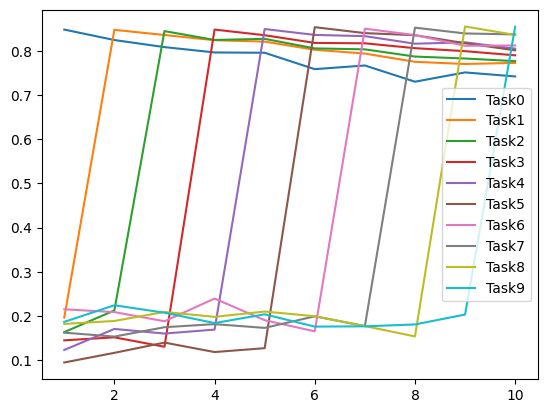

In [173]:
# lineplot every task acc per training
sns.lineplot(data=acc_df, dashes=False)